In [1]:
from skimage import io
import numpy as np
import mrcfile
import matplotlib.pyplot as plt

In [2]:
# reference: 
# https://discuss.cryosparc.com/t/differences-between-2d-ctf-when-viewed-in-cryosparc-vs-exported-ctf-diag-image-path/10511/6
# only change n. to np.
def contrast_normalization(arr_bin, tile_size = 128):
    '''
    Computes the minimum and maximum contrast values to use
    by calculating the median of the 2nd/98th percentiles
    of the mic split up into tile_size * tile_size patches.
    :param arr_bin: the micrograph represented as a numpy array
    :type arr_bin: list
    :param tile_size: the size of the patch to split the mic by 
        (larger is faster)
    :type tile_size: int
    '''
    ny,nx = arr_bin.shape
    # set up start and end indexes to make looping code readable
    tile_start_x = np.arange(0, nx, tile_size)
    tile_end_x = tile_start_x + tile_size
    tile_start_y = np.arange(0, ny, tile_size)
    tile_end_y = tile_start_y + tile_size
    num_tile_x = len(tile_start_x)
    num_tile_y = len(tile_start_y)
    
    # initialize array that will hold percentiles of all patches
    tile_all_data = np.empty((num_tile_y*num_tile_x, 2), dtype=np.float32)

    index = 0
    for y in range(num_tile_y):
        for x in range(num_tile_x):
            # cut out a patch of the mic
            arr_tile = arr_bin[tile_start_y[y]:tile_end_y[y], tile_start_x[x]:tile_end_x[x]]
            # store 2nd and 98th percentile values
            tile_all_data[index:,0] = np.percentile(arr_tile, 98)
            tile_all_data[index:,1] = np.percentile(arr_tile, 2)
            index += 1

    # calc median of non-NaN percentile values
    all_tiles_98_median = np.nanmedian(tile_all_data[:,0])
    all_tiles_2_median = np.nanmedian(tile_all_data[:,1])
    vmid = 0.5*(all_tiles_2_median+all_tiles_98_median)
    vrange = abs(all_tiles_2_median-all_tiles_98_median)
    extend = 1.5
    # extend vmin and vmax enough to not include outliers
    vmin = vmid - extend*0.5*vrange
    vmax = vmid + extend*0.5*vrange

    return vmin, vmax

In [3]:
# read .tiff raw movie (a .tiff file of cryosparc T20S tutorial dataset)
tiff = io.imread('14sep05c_00024sq_00003hl_00002es.frames.tif')
print('read tiff type: ', type(tiff))
print('data type of tiff data: ', tiff.dtype)
print('shape of tiff raw movie data:', tiff.shape)
print('max in tiff is: ', tiff.max())
print('min in tiff is: ', tiff.min())

read tiff type:  <class 'numpy.ndarray'>
data type of tiff data:  uint8
shape of tiff raw movie data: (38, 7676, 7420)
max in tiff is:  15
min in tiff is:  0


Open the raw movie tiff data as a numpy array. This tiff file is one of movies in cryosparc T20S tutorial data. As you can see, the data type is uint8, meaning integers in range [0, 255]. From the shape of tiff data, we know that there are 38 frames in each tiff file, and each frame is in shape (7676, 7420).
In the whole (38, 7676, 7420) tiff data, the max value is 15, and the min value is 0. All values are integers.

In [4]:
# sum over frames and save
tiffsum = np.sum(tiff, axis=0)
print('tiffsum type: ', type(tiffsum))
print('data type of tiffsum data: ', tiffsum.dtype)
print('shape of tiffsum data:', tiffsum.shape)
print('max in tiffsum is: ', tiffsum.max())
print('min in tiffsum is: ', tiffsum.min())
io.imsave('tiffsum.png', tiffsum.astype(np.uint8))

tiffsum type:  <class 'numpy.ndarray'>
data type of tiffsum data:  uint32
shape of tiffsum data: (7676, 7420)
max in tiffsum is:  363
min in tiffsum is:  0


Sum the tiff data over frames, and get a data in shape of (7676, 7420). The data type becomes uint32, meaning integers in range [0 : 4294967295]. Max value and min value are 363 and 0.

In [5]:
# use contrast_normalization function of cryosparc to adjust the summed tiff data
vmin, vmax = contrast_normalization(tiffsum, tile_size=128)
print('vmin is: ', vmin)
print('vmax is: ', vmax, '\n')
tiffsumclip = np.clip(tiffsum, vmin, vmax)
print('tiffsumclip type: ', type(tiffsumclip))
print('data type of tiffsumclip data: ', tiffsumclip.dtype)
print('shape of tiffsumclip data:', tiffsumclip.shape)
print('max in tiffsumclip is: ', tiffsumclip.max())
print('min in tiffsumclip is: ', tiffsumclip.min(), '\n')
tiffsumclipgray = (tiffsumclip - tiffsumclip.min()) / (tiffsumclip.max() - tiffsumclip.min()) * 255
print('tiffsumclipgray type: ', type(tiffsumclipgray))
print('data type of tiffsumclipgray data: ', tiffsumclipgray.dtype)
print('shape of tiffsumclipgray data:', tiffsumclipgray.shape)
print('max in tiffsumclipgray is: ', tiffsumclipgray.max())
print('min in tiffsumclipgray is: ', tiffsumclipgray.min())
io.imsave('tiffsumclipgray.png', tiffsumclipgray)

vmin is:  3.75
vmax is:  29.25 

tiffsumclip type:  <class 'numpy.ndarray'>
data type of tiffsumclip data:  float64
shape of tiffsumclip data: (7676, 7420)
max in tiffsumclip is:  29.25
min in tiffsumclip is:  3.75 

tiffsumclipgray type:  <class 'numpy.ndarray'>
data type of tiffsumclipgray data:  float64
shape of tiffsumclipgray data: (7676, 7420)
max in tiffsumclipgray is:  255.0
min in tiffsumclipgray is:  0.0


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Adjust the summed tiff data using contrast_normalization function. The function return vmin and vmax, and we clip the summed data: if a value is smaller than vmin, then it is set to vmin; if a value is bigger than vmax, it is set to vmax. Finally, all pixel values are in range [vmin, vmax]. After that, we map the value linearly to [0, 255], and save the image in gray scale. Here we save it in .png file which require uint8 data type. You can also save the clipped data in other format with higher precision. Whether make the range of data to [0, 255] depends on your choice.

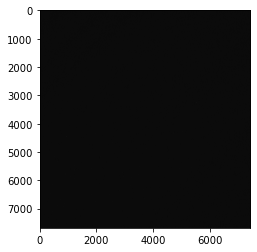

In [6]:
# display the summed tiff data directly
plt.imshow(tiffsum, cmap='gray')

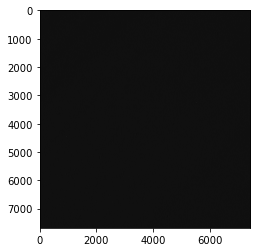

In [7]:
plt.imshow(tiffsum, vmin=0, vmax=255, cmap='gray')

Displaying directly results in a dark image.

adjusted type:  <class 'numpy.ndarray'>
data type of adjusted data:  uint8
shape of adjusted data: (7676, 7420)
max in adjusted is:  255
min in adjusted is:  0


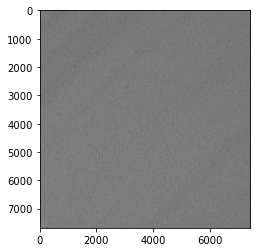

In [8]:
# display after contrast_normalization adjustment
adjusted = io.imread('tiffsumclipgray.png')
print('adjusted type: ', type(adjusted))
print('data type of adjusted data: ', adjusted.dtype)
print('shape of adjusted data:', adjusted.shape)
print('max in adjusted is: ', adjusted.max())
print('min in adjusted is: ', adjusted.min())
plt.imshow(adjusted, cmap='gray')

After adjustment, the image is human readable. Though the image is only summed and no gain reference is applied, we can see particles in the micrographs.

vmin is:  3.75
vmax is:  29.25


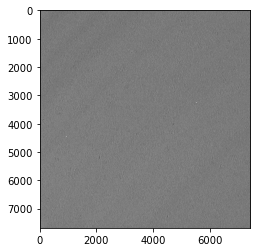

In [9]:
# use contrast_normalization function of cryosparc to display the image directly
vmin, vmax = contrast_normalization(tiffsum, tile_size=128)
print('vmin is: ', vmin)
print('vmax is: ', vmax)
plt.imshow(tiffsum, vmin=vmin, vmax=vmax, cmap='gray')

Another way to display the summed tiff (micrograph) data. Plot the image using plt.imshow directly with vmin and vmax. In my understanding and according to https://stackoverflow.com/questions/31232733/vmin-vmax-algorithm-matplotlib, it's the same with np.clip way.